<a href="https://colab.research.google.com/github/hessikaveh/TabNet-Test/blob/main/TabNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Let's try the Tabnet with Ludwig and compare it with the XGBoost
**First** Lets grab the data

In [ ]:
!pip install h5py

In [1]:
    # ------------------------------------------
    # load pickled numpy arrays or HDF5 as input data
    # ------------------------------------------
    def unpickle(fileName):
        # pickled and gzipped numpy arrays
        if fileName.endswith('.dmpz') or fileName.endswith('.dmp'):
            inputFile = gzip.open(fileName,'rb') if fileName.endswith('.dmpz') else open(fileName, "rb")
            try:
                data = pickle.load(inputFile, encoding='latin1')
            except:
                data = pickle.load(inputFile)
            inputFile.close()
        # HDF5 (smaller, recommended)
        elif fileName.endswith('.h5') or fileName.endswith('.hdf5'):
            data = {}
            with h5py.File(fileName, "r") as f:
                for k in ['meta', 'category_labels']:
                    data[k] = dict(json.loads(f.attrs[k])) #py3 no .decode('utf-8') needed
                for k in ['train', 'test']:
                    data[k] = {k2: f.get(k + '/' + k2)[:] for k2 in ['X', 'y']}
                    #optional: 'sample_weight', 'sample_weight_error'
                    try:
                        data[k]['sample_weight'] = f.get(k + '/sample_weight')[:]
                    except:
                        data[k]['sample_weight'] = np.full(len(data[k]['y']), 1.0, dtype=np.float32)
                    try:
                        data[k]['sample_weight_error'] = f.get(k + '/sample_weight_error')[:]
                    except:
                        data[k]['sample_weight_error'] = np.full(len(data[k]['y']), 0.0, dtype=np.float32)

                try:
                    for k in ['data']:
                        data[k] = {k2: f.get(k + '/' + k2)[:] for k2 in ['X']}
                    print("INFO: DATA included in H5 file, can make DATA/MC plots!")
                except:
                    pass

        # print meta data
        if 'meta' in data:
            print("INFO: read inputs from disk, metadata is pesent:")
            for k in sorted(data['meta'].keys()):
                print("INFO:  >  ",k,data['meta'][k])
        return data

In [3]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
# download the data
if not 'data_summer.h5' in os.listdir():
    print('Downloading data:')
    !wget https://github.com/hessikaveh/VHbbPytorch/raw/master/data_summer.h5 -O data_summer.h5
else:
    print('Data already downloaded')
    print(os.listdir())
    
# prepare the data


#df = pd.read_pickle('MadGraph.pkl')
#features = ['MET', 'pTB1', 'pTB2', 'dRBB', 'dEtaBB', 'dPhiMETdijet']
#X = df[features]
#Y = df[['Y']]
all_features = ['H_mass_fit_fallback', 'H_pt_fit_fallback', 'V_pt', 'nAddJets_2lep', 'SA5', 'V_mass', 'MET_Pt', 'hJets_leadingPt', 'hJets_subleadingPt', 'jjVPtRatio', 'HJ1_HJ2_dEta', 'HVdPhi_fit_fallback', 'hJets_btagged_0', 'hJets_btagged_1', 'HJ1_HJ2_dR', 'n_recoil_jets_fit', 'H_mass_sigma_fit']
features = ['H_pt_fit_fallback', 'V_pt', 'nAddJets_2lep', 'SA5', 'V_mass', 'MET_Pt', 'hJets_leadingPt', 'hJets_subleadingPt', 'jjVPtRatio', 'HJ1_HJ2_dEta', 'HVdPhi_fit_fallback', 'hJets_btagged_0', 'hJets_btagged_1', 'HJ1_HJ2_dR', 'n_recoil_jets_fit', 'H_mass_sigma_fit']
#data = unpickle("/content/drive/My Drive/vhbb/data_withCompleteCuts.h5")
data = unpickle("data_withCompleteCuts.h5")
X_train = data['train']['X']
Y_train = data['train']['y']
sample_weight_train = data['train']['sample_weight']
sample_weight_train = pd.DataFrame(sample_weight_train, columns=['weight'])
X_train = pd.DataFrame(X_train, columns=all_features)
Y_train = pd.DataFrame(Y_train, columns=['Y'])
Y_train['Y'].replace({0: 2, 1: 3}, inplace=True)
Y_train['Y'].replace({2: 1, 3: 0}, inplace=True)
Z_train = X_train[['H_mass_fit_fallback']]

X_test = data['test']['X']
Y_test = data['test']['y']
sample_weight_test = data['test']['sample_weight']
sample_weight_test = pd.DataFrame(sample_weight_test, columns=['weight'])
X_test = pd.DataFrame(X_test, columns=all_features)
Y_test = pd.DataFrame(Y_test, columns=['Y'])
Y_test['Y'].replace({0: 2, 1: 3}, inplace=True)
Y_test['Y'].replace({2: 1, 3: 0}, inplace=True)
Z_test = X_test[['H_mass_fit_fallback']]

del X_test['H_mass_fit_fallback']
del X_train['H_mass_fit_fallback']

#print(Z)
# preprocessing
X = pd.concat([X_train, X_test],axis=0, join='inner')
Y = pd.concat([Y_train, Y_test],axis=0, join='inner')
sample_weight = pd.concat([sample_weight_train, sample_weight_test],axis=0, join='inner')
Z = pd.concat([Z_train, Z_test],axis=0, join='inner')
X_pca = PCA(X.shape[1], svd_solver='auto', whiten=True)
Z_pca = PCA(Z.shape[1], svd_solver='auto', whiten=True)

X_pca.fit(X)
Z_pca.fit(Z)
df = pd.concat([X, Y, sample_weight],axis=1)
df_train = pd.concat([X_train, Y_train],axis=1)
df_test = pd.concat([X_test, Y_test],axis=1)
df['Y'].replace({0: 2, 1: 3}, inplace=True)
df['Y'].replace({2: 1, 3: 0}, inplace=True)

print (df)
# split
#X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, Y, Z)

def generate_hbb(n_samples, train=True):
    
    # test or train
    X_full = X_train if train else X_test
    Y_full = Y_train if train else Y_test
    Z_full = Z_train if train else Z_test
    weights_full = sample_weight_train if train else sample_weight_test
    # sample the events
    random_state = np.random.randint(0, 10000)
    X = X_full.sample(n_samples, random_state=random_state)
    Y = Y_full.sample(n_samples, random_state=random_state)
    Z = Z_full.sample(n_samples, random_state=random_state)
    weights = weights_full.sample(n_samples, random_state=random_state)
    # preprocess them
    #return X_pca.transform(X), Y.values, Z_pca.transform(Z), weights.values
    return X.values, Y.values, Z.values, weights.values
X, Y, Z, weights = generate_hbb(500, train=True)

Data already downloaded
['.config', 'data_withCompleteCuts.h5', 'data_summer.h5', 'sample_data']
INFO: read inputs from disk, metadata is pesent:
INFO:  >   variables H_mass_fit_fallback H_pt_fit_fallback V_pt nAddJets_2lep SA5 V_mass MET_Pt hJets_leadingPt hJets_subleadingPt jjVPtRatio HJ1_HJ2_dEta HVdPhi_fit_fallback hJets_btagged_0 hJets_btagged_1 HJ1_HJ2_dR n_recoil_jets_fit H_mass_sigma_fit
        H_pt_fit_fallback        V_pt  ...    Y    weight
0              227.006790  229.563721  ...  1.0  0.000180
1              153.907333  154.488251  ...  1.0  0.000072
2              155.563187  190.107605  ...  1.0  0.000091
3               18.904070  201.898819  ...  1.0  0.000100
4              169.643005  168.136353  ...  1.0  0.000098
...                   ...         ...  ...  ...       ...
320941         179.484482  247.384338  ...  0.0  0.029284
320942          42.163162  177.791473  ...  0.0  0.008704
320943         138.841492  188.240845  ...  0.0  0.000708
320944         262.49

### Show the data

Here, let's take a look at a few kinematic variables for the signal and background samples.

H_pt_fit_fallback
V_pt
nAddJets_2lep
SA5
V_mass
MET_Pt
hJets_leadingPt
hJets_subleadingPt
jjVPtRatio
HJ1_HJ2_dEta
HVdPhi_fit_fallback
hJets_btagged_0
hJets_btagged_1
HJ1_HJ2_dR
n_recoil_jets_fit
H_mass_sigma_fit


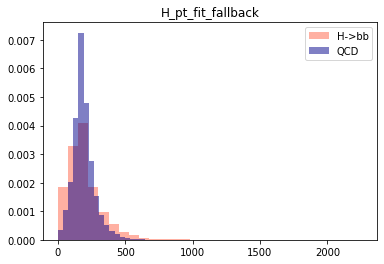

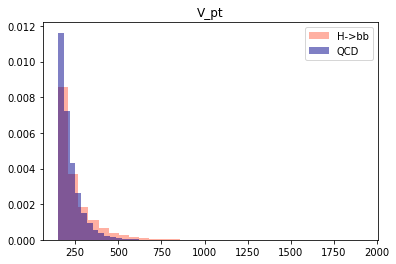

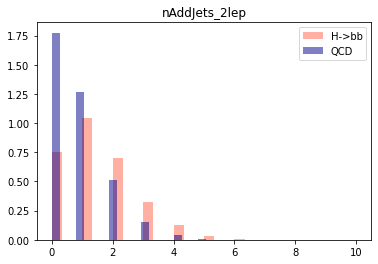

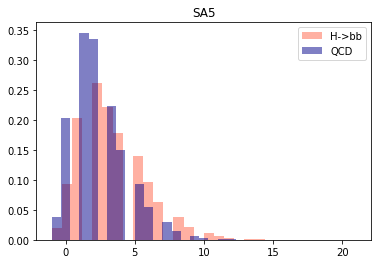

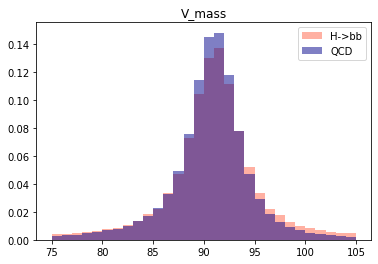

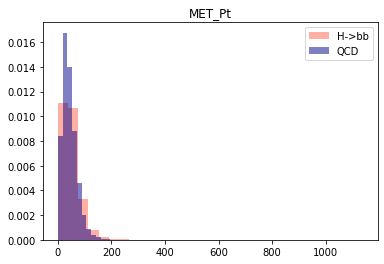

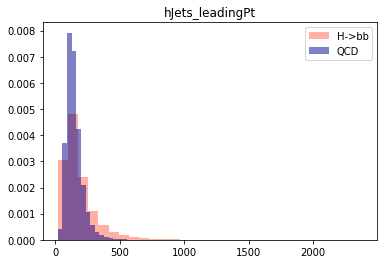

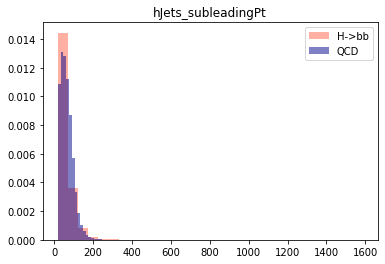

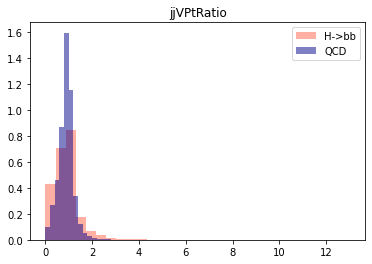

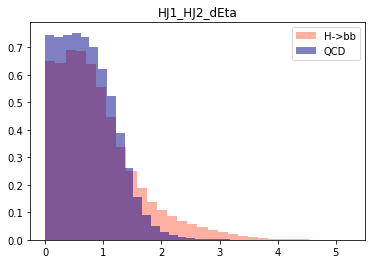

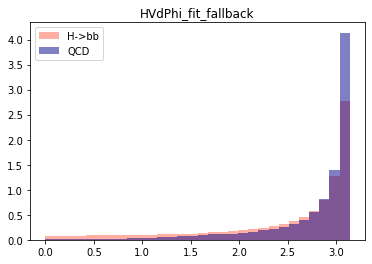

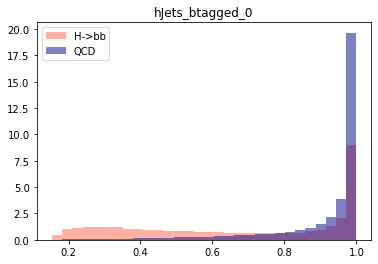

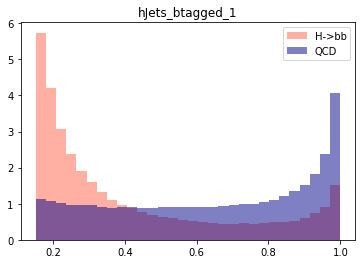

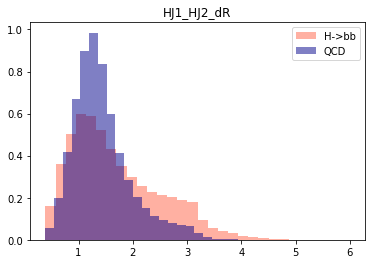

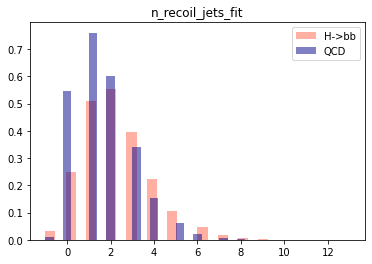

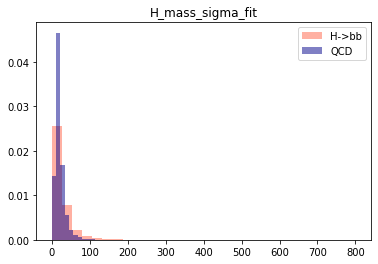

In [5]:
for feature in features:
    fig, ax = plt.subplots()
    print(feature)
    _ = ax.hist(df.query('Y==0')[feature], bins=30, alpha=0.5, density=True, color='tomato', label='H->bb')
    _ = ax.hist(df.query('Y==1')[feature], bins=30, alpha=0.5, density=True, color='darkblue', label='QCD')
    ax.set_title(feature)
    ax.legend(loc='best')

### XGBoost

[11:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


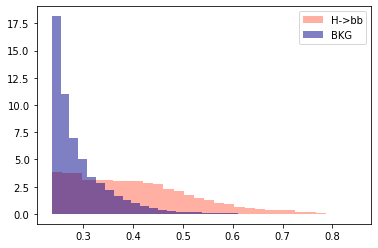

In [9]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,Y_train)

preds = xg_reg.predict(X_test)
weights = pd.concat([sample_weight_test, Y_test], axis=1)
yhat_df = pd.DataFrame(preds)
yhat_pred = pd.concat([yhat_df, Y_test], axis=1)
fig, ax = plt.subplots()
_ = ax.hist(yhat_pred[yhat_pred['Y']==1][0], bins=30, alpha=0.5, density=True, color='tomato', label='H->bb', weights =[ weights[weights['Y']==1]['weight'] ])
_ = ax.hist(yhat_pred[yhat_pred['Y']==0][0], bins=30, alpha=0.5, density=True, color='darkblue', label='BKG', weights =[ weights[weights['Y']==0]['weight'] ])
ax.legend()

In [10]:
# define the model
model = XGBClassifier()
# define the datasets to evaluate each iteration
evalset = [(X_train, Y_train), (X_test,Y_test)]
# fit the model
model.fit(X_train, Y_train, eval_metric='logloss', eval_set=evalset)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-logloss:0.646712	validation_1-logloss:0.646809
[1]	validation_0-logloss:0.608314	validation_1-logloss:0.608472
[2]	validation_0-logloss:0.57833	validation_1-logloss:0.578477
[3]	validation_0-logloss:0.552107	validation_1-logloss:0.5523
[4]	validation_0-logloss:0.529118	validation_1-logloss:0.529352
[5]	validation_0-logloss:0.511065	validation_1-logloss:0.511378
[6]	validation_0-logloss:0.494984	validation_1-logloss:0.495372
[7]	validation_0-logloss:0.48076	validation_1-logloss:0.481196
[8]	validation_0-logloss:0.469126	validation_1-logloss:0.469589
[9]	validation_0-logloss:0.458993	validation_1-logloss:0.459506
[10]	validation_0-logloss:0.450324	validation_1-logloss:0.450815
[11]	validation_0-logloss:0.44251	validation_1-logloss:0.443042
[12]	validation_0-logloss:0.435738	validation_1-logloss:0.436332
[13]	validation_0-logloss:0.429869	validation_1-logloss:0.430486
[14]	validation_0-logloss:0.4249	validation_1-logloss:0.425495
[15]	validation_0-logloss:0.420577	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [11]:
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(Y_test, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.853


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(512, activation="relu", name="layer1"),
        layers.Dense(256, activation="relu", name="layer2"),
        layers.Dense(128, activation="relu", name="layer3"),
        layers.Dense(64, activation="relu", name="layer4"),
        layers.Dense(64, activation="relu", name="layer5"),
        layers.Dense(2, activation="sigmoid", name="layer6"),
    ]
)
#2, 256, 128, 64, 64 and124964 nodes

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model, 'temp.png', show_shapes=True)

model.compile('adam', 'sparse_categorical_crossentropy')
 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
print( Counter(Y_test) )
# uneven classes

print('Training:')
try:
    model.fit(
        X_train, Y_train,
        callbacks = [
            EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
            ModelCheckpoint('tutorial-progress.h5', monitor='val_loss', verbose=True, save_best_only=True)
        ],
        epochs=40, 
        validation_split = 0.2,
        verbose=True
) 
except KeyboardInterrupt:
    print( 'Training ended early.' )
# -- load in best network
model.load_weights('tutorial-progress.h5')

# -- Save network weights and structure
print( 'Saving model...' )
model.save_weights('tutorial.h5', overwrite=True)
json_string = model.to_json()
open('tutorial.json', 'w').write(json_string)
print( 'Done' )

print( 'Testing...' )
yhat = model.predict(X_test, verbose = True, batch_size = 8080) 

# predictions
print(yhat)

Counter({'Y': 1})
Training:
Epoch 1/40
8080/8080 [==============================] - 41s 5ms/step - loss: 0.0992 - val_loss: 4.6310

Epoch 00001: val_loss improved from inf to 4.63096, saving model to tutorial-progress.h5
Epoch 2/40
8080/8080 [==============================] - 39s 5ms/step - loss: 0.0924 - val_loss: 4.3304

Epoch 00002: val_loss improved from 4.63096 to 4.33037, saving model to tutorial-progress.h5
Epoch 3/40
8080/8080 [==============================] - 39s 5ms/step - loss: 0.0913 - val_loss: 4.2621

Epoch 00003: val_loss improved from 4.33037 to 4.26215, saving model to tutorial-progress.h5
Epoch 4/40
8080/8080 [==============================] - 39s 5ms/step - loss: 0.0906 - val_loss: 4.6533

Epoch 00004: val_loss did not improve from 4.26215
Epoch 5/40
8080/8080 [==============================] - 39s 5ms/step - loss: 0.0899 - val_loss: 3.6624

Epoch 00005: val_loss improved from 4.26215 to 3.66242, saving model to tutorial-progress.h5
Epoch 6/40
8080/8080 [===========

In [14]:
yhat = model.predict(X_test)
yhat_cls = np.argmax(yhat, axis=1)
score = accuracy_score(Y_test, yhat_cls)
print('Accuracy: %.3f' % score)

Accuracy: 0.783


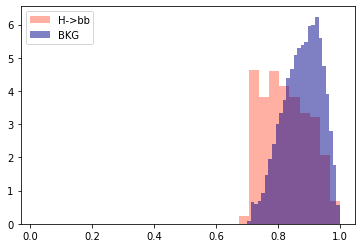

In [15]:
# -- turn them into classes
yhat_cls = np.argmax(yhat, axis=1)

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("confusion.png")

#print(yhat[:,0])
#print(yhat[:,1])
weights = pd.concat([sample_weight_test, Y_test], axis=1)
yhat_df = pd.DataFrame(yhat)
yhat_pred = pd.concat([yhat_df, Y_test], axis=1)
#print(weights[weights['Y']==1]['weight'], yhat_pred)
# Compute confusion matrix
#cnf_matrix = confusion_matrix(Y_test, yhat, sample_weight=sample_weight_test)
#cnf_matrix = confusion_matrix(Y_test, yhat_cls)
#np.set_printoptions(precision=2)
#plot_confusion_matrix(cnf_matrix, classes=['Hbb', 'Bkg'],
#                      normalize=True,
#                      title='Normalized confusion matrix')
# signal eff = weighted tpr --> out of all signal events, what % for we classify as signal?
#print ('Signal efficiency:', sample_weight_test[(yhat == 0)].sum() / sample_weight_test[yhat == 0].sum())

# bkg eff = weighted fpr --> out of all bkg events, what % do we classify as signal?
b_eff = weights[(Y_test != 0) ].sum() / weights[Y_test != 0].sum()
#print ('Background efficiency:', b_eff)
#print ('Background rej:', 1 / b_eff)
fig, ax = plt.subplots()
_ = ax.hist(yhat_pred[yhat_pred['Y']==1][0], bins=30, alpha=0.5, density=True, color='tomato', label='H->bb', weights =[ weights[weights['Y']==1]['weight'] ])
_ = ax.hist(yhat_pred[yhat_pred['Y']==0][0], bins=30, alpha=0.5, density=True, color='darkblue', label='BKG', weights =[ weights[weights['Y']==0]['weight'] ])
ax.legend()

In [16]:
import yaml
yaml_data = {'input_features': [{'name': 'H_pt_fit_fallback', 'type': 'numerical'}, {'name': 'V_pt', 'type': 'numerical'}, {'name': 'nAddJets_2lep', 'type': 'numerical'}, {'name': 'SA5', 'type': 'numerical'}, {'name': 'V_mass', 'type': 'numerical'}, {'name': 'MET_Pt', 'type': 'numerical'}, {'name': 'hJets_leadingPt', 'type': 'numerical'}, {'name': 'hJets_subleadingPt', 'type': 'numerical'}, {'name': 'jjVPtRatio', 'type': 'numerical'}, {'name': 'HJ1_HJ2_dEta', 'type': 'numerical'}, {'name': 'HVdPhi_fit_fallback', 'type': 'numerical'}, {'name': 'hJets_btagged_0', 'type': 'numerical'}, {'name': 'hJets_btagged_1', 'type': 'numerical'}, {'name': 'HJ1_HJ2_dR', 'type': 'numerical'}, {'name': 'n_recoil_jets_fit', 'type': 'numerical'}, {'name': 'H_mass_sigma_fit', 'type': 'numerical'}], 'output_features': [{'name': 'Y', 'type': 'binary', 'weight_regularization': None}], 'combiner': {'type': 'tabnet', 'size': 32, 'output_size': 96, 'sparsity': 1e-06, 'bn_virtual_divider': 32, 'bn_momentum': 0.9, 'num_steps': 8, 'relaxation_factor': 2, 'use_keras_batch_norm': False, 'bn_virtual_bs': 256}, 'training': {'batch_size': 8192, 'eval_batch_size': 500000, 'epochs': 1000, 'early_stop': 20, 'learning_rate': 0.025, 'optimizer': {'type': 'adam'}, 'decay': True, 'decay_steps': 10000, 'decay_rate': 0.9, 'staircase': True, 'regularization_lambda': 1, 'validation_field': 'Y', 'shuffle_buffer_size': 1500000}}

# Write YAML file
with open('higgs.yaml', 'w', encoding='utf8') as outfile:
    yaml.dump(yaml_data, outfile, default_flow_style=False, allow_unicode=True)

In [17]:
# Read YAML file
with open("higgs.yaml", 'r') as stream:
    yml_loaded = yaml.safe_load(stream)

print(yml_loaded)

{'combiner': {'bn_momentum': 0.9, 'bn_virtual_bs': 256, 'bn_virtual_divider': 32, 'num_steps': 8, 'output_size': 96, 'relaxation_factor': 2, 'size': 32, 'sparsity': 1e-06, 'type': 'tabnet', 'use_keras_batch_norm': False}, 'input_features': [{'name': 'H_pt_fit_fallback', 'type': 'numerical'}, {'name': 'V_pt', 'type': 'numerical'}, {'name': 'nAddJets_2lep', 'type': 'numerical'}, {'name': 'SA5', 'type': 'numerical'}, {'name': 'V_mass', 'type': 'numerical'}, {'name': 'MET_Pt', 'type': 'numerical'}, {'name': 'hJets_leadingPt', 'type': 'numerical'}, {'name': 'hJets_subleadingPt', 'type': 'numerical'}, {'name': 'jjVPtRatio', 'type': 'numerical'}, {'name': 'HJ1_HJ2_dEta', 'type': 'numerical'}, {'name': 'HVdPhi_fit_fallback', 'type': 'numerical'}, {'name': 'hJets_btagged_0', 'type': 'numerical'}, {'name': 'hJets_btagged_1', 'type': 'numerical'}, {'name': 'HJ1_HJ2_dR', 'type': 'numerical'}, {'name': 'n_recoil_jets_fit', 'type': 'numerical'}, {'name': 'H_mass_sigma_fit', 'type': 'numerical'}], 'o

In [18]:
print(df.head())

   H_pt_fit_fallback        V_pt  ...    Y    weight
0         227.006790  229.563721  ...  1.0  0.000180
1         153.907333  154.488251  ...  1.0  0.000072
2         155.563187  190.107605  ...  1.0  0.000091
3          18.904070  201.898819  ...  1.0  0.000100
4         169.643005  168.136353  ...  1.0  0.000098

[5 rows x 18 columns]


In [19]:
!pip install ludwig
!pip install petastorm


     |████████████████████████████████| 348kB 3.9MB/s 
     |████████████████████████████████| 9.5MB 301kB/s 
     |████████████████████████████████| 686kB 35.8MB/s 
     |████████████████████████████████| 122kB 39.2MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for ludwig: filename=ludwig-0.4-cp37-none-any.whl size=423617 sha256=55df39b393424f4c64bb7a10d5130bbf3d9edff928875a3640847ccd4b30afdd
  Stored in directory: /root/.cache/pip/wheels/eb/c3/fd/e4650be37a75afd05b639d747b479e041583e8cc6fc8f71b63
  Created wheel for stringcase: filename=stringcase-1.2.0-cp37-none-any.whl size=3588 sha256=82ca4d05a74edc3b75b74db617c8b507d30fc0ca7b9b1f2bc2fe1a39e78ff3bd
  Stored in directory: /root/.cache/pip/wheels/a0/16/a0/16e2c81dbd47503b5a35583dfabde5a93b4cf98dbf0033dad5
Successfully built ludwig stringcase
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


     |████████████████████████████████| 286kB 4.0MB/s 
     |████████████████████████████████| 212.4MB 68kB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 204kB 40.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=32571fb1eebaa2fe7352eabc44cb1299dcbb5dcd7604fb1d3790e245d48fa5e7
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [20]:
df.to_csv("higgs.csv")

In [21]:
!ludwig train --dataset higgs.csv --config higgs.yaml


2021-07-06 11:53:42.074963: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.4 - Train

2021-07-06 11:53:44.491589: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-06 11:53:44.504286: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-06 11:53:44.504367: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1fd7d2f0c291): /proc/driver/nvidia/version does not exist
Experiment name: experiment
Model name: run
Output directory: results/experiment_run


ludwig_version: '0.4'
command: '/usr/local/bin/ludwig train --dataset hi

![grafik](https://user-images.githubusercontent.com/13552751/124397591-0c91db00-dd11-11eb-8f7e-2056685df044.png)

![grafik](https://user-images.githubusercontent.com/13552751/124397618-39de8900-dd11-11eb-9d9f-e7dacce6394d.png)

###TabNet Combiner

The tabnet combiner implements the TabNet model, which uses attention and sparsity to achieve high performnce on tabular data. It assumes all outputs from encoders are tensors of size b x h where b is the batch size and h is the hidden dimension, which can be different for each input. If the input tensors have a different shape, it automatically flattens them. It returns the final b x h' tensor where h' is the user-specified output size.

These are the available parameters of a tabnet combiner:
* size: the size of the hidden layers. N_a in the paper.
* output_size: the size of the output of each step and of the final aggregated representation. N_d in the paper.
* num_steps (default 1): number of steps / repetitions of the the attentive transformer and feature transformer computations. N_steps in the paper.
* num_total_blocks (default 4): total number of feature transformer block at each step.
* num_shared_blocks (default 2): number of shared feature transformer blocks across the steps.
* relaxation_factor (default 1.5): Factor that influences how many times a feature should be used across the steps of computation. a value of 1 implies it each feature should be use once, a higher value allows for multiple usages. gamma in the paper.
* bn_epsilon (default 0.001): epsilon to be added to the batch norm denominator.
* bn_momentum (default 0.7): momentum of the batch norm. m_B in the paper.
* bn_virtual_bs (default null): size of the virtual batch size used by ghost batch norm. If null, regular batch norm is used instead. B_v from the paper.
* sparsity (default 0.00001): multiplier of the sparsity inducing loss. lambda_sparse in the paper.
* dropout (default 0): dropout rate.


#Visualization 

In [22]:
from ludwig.utils.data_utils import load_json
from ludwig.visualize import learning_curves
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns

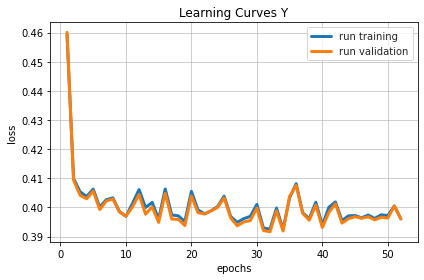

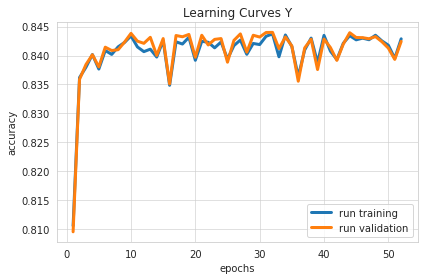

In [25]:
# retrieve training statistics
list_of_stats = []
list_of_models = []

for model in ['run']:
    experiment_model_dir = './results/experiment_' + model 
    train_stats = load_json(os.path.join(experiment_model_dir,'training_statistics.json'))
    ground_truth_metadata = load_json(os.path.join(experiment_model_dir+'/model/','training_set_metadata.json'))
    list_of_stats.append(train_stats)
    list_of_models.append(model)
    

# generating learning curves from training
learning_curves(list_of_stats, 'Y',
                model_names=list_of_models,
                output_directory='./visualizations',
                file_format='png')

In [26]:
# function to generate pandas data frame from training statistcs
# Parameter:
#   experiment_model_dir: directory containing the training statistics for a specific model training experiment
#
# Returns: pandas dataframe containing the performance metric and loss
#

def extract_training_stats(experiment_model_dir):
    list_of_splits = ['training', 'validation', 'test']
    list_of_df = []
    for split in list_of_splits:
        train_stats = load_json(os.path.join(experiment_model_dir,'training_statistics.json'))
        df = pd.DataFrame(train_stats[split]['combined'])
        df.columns = [split + '_' + c for c in df.columns]
        list_of_df.append(df)
        
    df = pd.concat(list_of_df, axis=1)
    df['epoch'] = df.index + 1
        
    return df

In [27]:
model1 = extract_training_stats('./results/experiment_run')
model1.name = 'model'

In [28]:
model1

,training_loss,validation_loss,test_loss,epoch
0,0.459396,0.460072,0.460331,1
1,0.409928,0.409365,0.410427,2
2,0.405369,0.404148,0.405425,3
3,0.403752,0.402975,0.403430,4
4,0.406270,0.405616,0.406718,5
5,0.400094,0.399262,0.399820,6
6,0.402642,0.402211,0.403101,7
7,0.403299,0.402911,0.403762,8
8,0.398628,0.398460,0.399319,9
9,0.396944,0.397020,0.396856,10


In [ ]:
!rm tabnet.tar.gz
!tar -czf tabnet.tar.gz .

rm: cannot remove 'tabnet.tar.gz': No such file or directory
tar: ./tabnet.tar.gz: file changed as we read it


In [30]:
!ludwig predict --dataset higgs.csv --model_path results/experiment_run/model/

2021-07-06 16:00:07.664301: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.4 - Predict

Dataset path: higgs.csv
Model path: results/experiment_run/model/

2021-07-06 16:00:11.736542: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-06 16:00:11.750182: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-06 16:00:11.750304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1fd7d2f0c291): /proc/driver/nvidia/version does not exist
Loading metadata from: results/experiment_run/model/training_set_metadata.json
Prediction:

In [31]:
yhat = np.load('results/Y_predictions.npy')
score = accuracy_score(df['Y'], yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.844


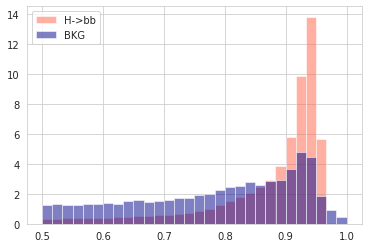

In [32]:
preds = np.load('results/Y_probability.npy')
weights = pd.concat([df['weight'], df['Y']], axis=1)
yhat_df = pd.DataFrame(preds)
yhat_df.reset_index(drop=True, inplace=True)
weights.reset_index(drop=True, inplace=True)

yhat_pred = pd.concat([yhat_df, weights], axis=1)
#print(yhat_pred)
fig, ax = plt.subplots()
_ = ax.hist(yhat_pred[yhat_pred['Y']==1][0], bins=30, alpha=0.5, density=True, color='tomato', label='H->bb', weights =[ weights[weights['Y']==1]['weight'] ])
_ = ax.hist(yhat_pred[yhat_pred['Y']==0][0], bins=30, alpha=0.5, density=True, color='darkblue', label='BKG', weights =[ weights[weights['Y']==0]['weight'] ])
ax.legend()